In [27]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import random as python_random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
!ls

README.md    dl_load.ipynb     resnet-jordan.ipynb  resnet_v2.ipynb
checkpoints  jordan_cnn.ipynb  resnet.ipynb	    saved_models


In [32]:
data_path = '../dl_data/'
class_names = os.listdir(data_path)
for c in class_names:
    print(c)
    print(len(os.listdir(data_path + c)))

Covid_img
3610
Viral_img
1345
Normal_img
10192


In [4]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image

data_dir = "../dl_data"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)     

Found 15147 files belonging to 3 classes.
Using 12118 files for training.


2022-04-12 11:30:56.662362: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 11:30:58.691340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9625 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5


Found 15147 files belonging to 3 classes.
Using 3029 files for validation.


In [5]:
validation_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

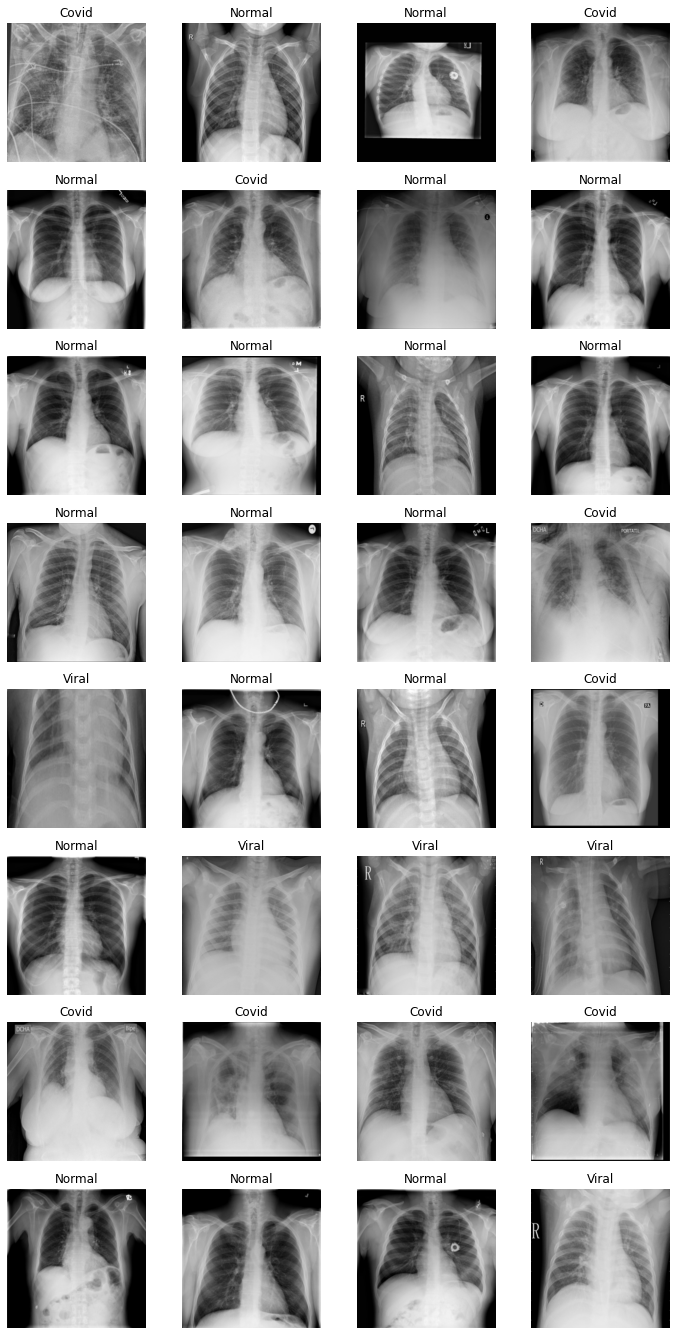

In [30]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['Covid',  'Normal',  'Viral']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [7]:
# set checkpoint to resume training if it stops unexpectedly
checkpoint_path = "checkpoints/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [8]:
ds_size_1 = (224, 224)
train_ds_1 = train_ds.map(lambda image, label: (tf.image.resize(image, ds_size_1), label))
validation_ds_1 = validation_ds.map(lambda image, label: (tf.image.resize(image, ds_size_1), label))

base_model_1 = keras.applications.ResNet50(weights='imagenet', include_top=False)
n_classes = 18

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model_1.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="pred")(x) # match number of classes

model_1 = keras.models.Model(inputs=base_model_1.input,
                           outputs=outputs)

In [9]:
# train up the top layer first

for layer in base_model_1.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=0.01)
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model_1.fit(train_ds_1,
                    validation_data=validation_ds_1,
                    epochs=20, callbacks=[callback,cp_callback])

Epoch 1/20


2022-04-12 11:31:08.259390: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


379/379 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.9060
Epoch 1: saving model to checkpoints/training_1/cp.ckpt
379/379 [==============================] - 30s 56ms/step - loss: 0.4419 - accuracy: 0.9060 - val_loss: 0.1859 - val_accuracy: 0.9475
Epoch 2/20
379/379 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9395
Epoch 2: saving model to checkpoints/training_1/cp.ckpt
379/379 [==============================] - 20s 53ms/step - loss: 0.2114 - accuracy: 0.9395 - val_loss: 0.1527 - val_accuracy: 0.9554
Epoch 3/20
379/379 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9438
Epoch 3: saving model to checkpoints/training_1/cp.ckpt
379/379 [==============================] - 20s 53ms/step - loss: 0.1727 - accuracy: 0.9438 - val_loss: 0.1305 - val_accuracy: 0.9597
Epoch 4/20
379/379 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9518
Epoch 4: saving model to checkpoints/training_1/cp.ckpt
379/

In [10]:
# train all the layers together for a bit with a much lower learning rate

for layer in base_model_1.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.0004, decay=0.001)
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model_1.fit(train_ds_1,
                    validation_data=validation_ds_1,
                    epochs=50, callbacks=[callback,cp_callback])

Epoch 1/50
379/379 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9292
Epoch 1: saving model to checkpoints/training_1/cp.ckpt
379/379 [==============================] - 28s 64ms/step - loss: 0.2139 - accuracy: 0.9292 - val_loss: 0.2635 - val_accuracy: 0.9353
Epoch 2/50
378/379 [============================>.] - ETA: 0s - loss: 0.0943 - accuracy: 0.9684
Epoch 2: saving model to checkpoints/training_1/cp.ckpt
379/379 [==============================] - 23s 62ms/step - loss: 0.0944 - accuracy: 0.9684 - val_loss: 0.1655 - val_accuracy: 0.9587
Epoch 3/50
379/379 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9809
Epoch 3: saving model to checkpoints/training_1/cp.ckpt
379/379 [==============================] - 23s 62ms/step - loss: 0.0577 - accuracy: 0.9809 - val_loss: 0.1658 - val_accuracy: 0.9571
Epoch 4/50
378/379 [============================>.] - ETA: 0s - loss: 0.0379 - accuracy: 0.9864
Epoch 4: saving model to checkpoints/training_1/c

In [15]:
# save the model
model_1.save('saved_models/model_1') # change this path to save a new version

INFO:tensorflow:Assets written to: saved_models/model_1/assets


In [16]:
# # if you need to use the checkpoint, use this code
# # source: https://www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_options

# latest = tf.train.latest_checkpoint(checkpoint_dir)
# latest

# # Create a new model instance
# model_1 = create_model()

# # Load the previously saved weights
# model_1.load_weights(latest)

# # Re-evaluate the model
# loss, acc = model_1.evaluate(validation_ds_1 verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [17]:
predictions_1 = model_1.predict(validation_ds_1, batch_size=batch_size)
len(predictions_1)

# or get predeictions from saved model

# saved_model_1 = tf.keras.models.load_model('saved_model/my_model')
# predictions_1 = saved_model_1.predict(validation_ds_1)

3029

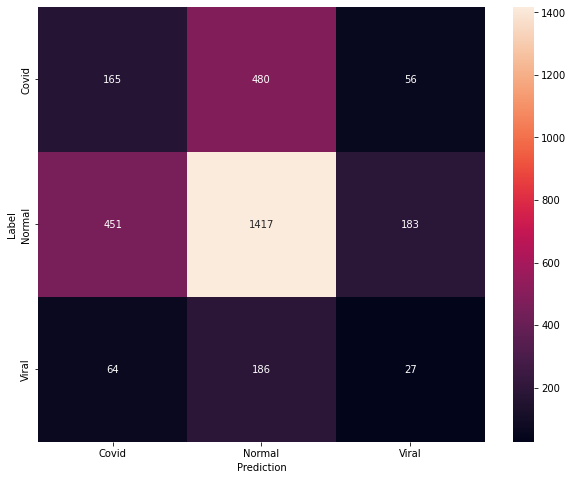

In [31]:
# https://www.tensorflow.org/tutorials/audio/simple_audio#display_a_confusion_matrix
# con_matrix = tf.math.confusion_matrix(
#     labels,
#     predictions,
#     num_classes=None,
#     weights=None,
#     dtype=tf.dtypes.int32,
#     name=None
# )

y_true = []
for img, label in validation_ds_1:
    y_true.append(label.numpy())
y_true

# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    np.argmax(predictions_1, axis=1),
    num_classes=3,
    weights=None) # change to get to 100% covid accuracy
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
y_true = []
sz = 0
for img, label in validation_ds_1:
    y_true.append(label.numpy())
    sz += len(label.numpy())
print(sz)
len(y_true)


y_pred = np.argmax(model.predict(test_audio), axis=1)

In [25]:
np.argmax(predictions_1, axis=1)

array([1, 0, 1, ..., 0, 1, 1])

In [39]:
len(np.concatenate(y_true))

3029

In [40]:
tf.convert_to_tensor(np.concatenate(y_true))

<tf.Tensor: shape=(3029,), dtype=int32, numpy=array([1, 1, 1, ..., 1, 1, 1], dtype=int32)>